# Machine Learning: Multiple Regression/Linear Models to Predict Home Sale Prices

The goal of this analysis is to develop a model that predicts home sale prices from a detailed dataset of home features.

The dataset that I will be using includes 2930 observations and 80 variables describing homes in Ames, Iowa which sold between 2006 and 2010. A description on how and why it was created can be found [here](https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627) and descriptions of the features in the dataset can be found [here](https://s3.amazonaws.com/dq-content/307/data_description.txt).

## Libraries

In order to import and manipulate the data in dataframes, I'll be using the Pandas library. For matrix operations, I'll be leveraging Numpy. The regression model will be preprocessed, fit and measured using sci-kit learn. Matplotlib.pyplot and Seaborn will be used for any necessary visualizations.

In [1]:
import pandas as pd
pd.options.display.max_columns = 999
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
import seaborn as sns
from scipy import stats

## Import Data

In [2]:
data = pd.read_csv('AmesHousing.tsv', delimiter='\t')

In [3]:
print(data.head())

   Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0      1  526301100           20        RL         141.0     31770   Pave   
1      2  526350040           20        RH          80.0     11622   Pave   
2      3  526351010           20        RL          81.0     14267   Pave   
3      4  526353030           20        RL          93.0     11160   Pave   
4      5  527105010           60        RL          74.0     13830   Pave   

  Alley Lot Shape Land Contour Utilities Lot Config Land Slope Neighborhood  \
0   NaN       IR1          Lvl    AllPub     Corner        Gtl        NAmes   
1   NaN       Reg          Lvl    AllPub     Inside        Gtl        NAmes   
2   NaN       IR1          Lvl    AllPub     Corner        Gtl        NAmes   
3   NaN       Reg          Lvl    AllPub     Corner        Gtl        NAmes   
4   NaN       IR1          Lvl    AllPub     Inside        Gtl      Gilbert   

  Condition 1 Condition 2 Bldg Type House Style  Overall Qual 

## Meet the helper functions

Creating functions to handle various stages of the model fitting pipeline. This is an organizational choice, meant to modularize the feature transformation, selection and testing phases.

The initial functions execute a basic linear regression on a raw column, measures its performance using mean squared error as a cost function, and returns the square root to communicate the error in the original dollar scale (rmse).

1. **transform_features** - This function contains any steps that remove or alter the data. This will include missing value handling (removal or interpolation), removing features (due to data leak or irrelevance), rescaling or transforming features, or creating new features through combination.

2. **select_features** - This function passes features into the test/train model.

3. **test_and_train** - this is the main function for testing models and calculating error.

In [4]:
#### Transform Features
def transform_features(df):
    return df

In [5]:
#### Select Features
def select_features(df):
    df = df.copy()
    return df[['Gr Liv Area', 'SalePrice']]


In [6]:
#### Train and Test
def train_and_test(df):
    #partition data
    train = df[:1460]
    test = df[1460:]

    #Select features
    train_df = select_features(train)
    train_numeric = train_df.select_dtypes(include=['integer', 'float'])
    features = train_numeric.columns.drop('SalePrice')
    
    #fit and measure model performance - Linear Regression
    lr = LinearRegression()
    lr.fit(train_numeric[features], train_numeric[['SalePrice']])
    test_predict = lr.predict(test[features])
    mse_test = mean_squared_error(test['SalePrice'], test_predict)
    rmse_test = np.sqrt(mse_test)
    return rmse_test


## Feature engineering

In [7]:
##Missing Values - fillna for numerical cols w/less than 5% MV.
len_data = data.shape[0]
mv_total = data.isnull().sum()
mv_fill = mv_total[(mv_total < (len_data * .05)) & (mv_total > 0)]
print(mv_fill)
for col in mv_fill.index:
    if data[col].dtype in ('int', 'float'):
        mode = data[col].mode()
        data[col] = data[col].fillna(mode, inplace=True)

Mas Vnr Type      23
Mas Vnr Area      23
Bsmt Qual         80
Bsmt Cond         80
Bsmt Exposure     83
BsmtFin Type 1    80
BsmtFin SF 1       1
BsmtFin Type 2    81
BsmtFin SF 2       1
Bsmt Unf SF        1
Total Bsmt SF      1
Electrical         1
Bsmt Full Bath     2
Bsmt Half Bath     2
Garage Cars        1
Garage Area        1
dtype: int64


In [8]:
##Missing Values - drop cols missing > 5% of of total data.
drop_cols = mv_total[mv_total > (len_data * 0.05)]
print("These columns are dropped for high missing value count:")
print(drop_cols.index)
data = data.drop(drop_cols.index, axis=1)

These columns are dropped for high missing value count:
Index(['Lot Frontage', 'Alley', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
       'Garage Finish', 'Garage Qual', 'Garage Cond', 'Pool QC', 'Fence',
       'Misc Feature'],
      dtype='object')


In [9]:
##Missing Values - dropping text columns with mv
text_mv = data.select_dtypes('object').isnull().sum()
text_mv = text_mv[text_mv > 0]
print(text_mv) 
data = data.drop(text_mv.index, axis=1)


Mas Vnr Type        23
Mas Vnr Area      2930
Bsmt Qual           80
Bsmt Cond           80
Bsmt Exposure       83
BsmtFin Type 1      80
BsmtFin SF 1      2930
BsmtFin Type 2      81
BsmtFin SF 2      2930
Bsmt Unf SF       2930
Total Bsmt SF     2930
Electrical           1
Bsmt Full Bath    2930
Bsmt Half Bath    2930
Garage Cars       2930
Garage Area       2930
dtype: int64


#### Drop Data Leak Columns / Capture Remodel Data

Remove any columns that include information that wouldn't be knowable prior to the sale in order to make this model useful for predicting unsold houses later. This includes features that specify the sale date (month/year) and metadata for the transaction such as sale type or sale condition.

A recent remodel is likely to be a factor in a home's sale price, however; I won't be able to calculate how many years passed between a remodel and a sale if I remove the sale year first. A comprimise is to create a 'yrs since remodel' column using the sale data and remodel date prior to removing the year sold. Assuming this model will be used in future production, the sale year could easily substituted out in this feature's calculation for the current date. As many homes have not been remodeled, this data will overlap with Year Built in terms of the information that it is providing to the model for many locations. With this feature in the model, it makes sense to drop Year Built as well as this will convey the same info for many homes.

In [10]:
#Create 'yrs_since_remodel' feature. Remove nonsensical rows (< 0)
data['yrs_since_remodel'] = data['Yr Sold'] - data['Year Remod/Add']
neg_rows = data[data['yrs_since_remodel'] < 0].index
data = data.drop(neg_rows)

In [11]:
#Drop Data Leak Columns - contain information not knowable prior to sale.
data_leak_cols = ['Sale Condition', 'Yr Sold', 'Mo Sold', 'Sale Type']
data = data.drop(data_leak_cols, axis=1)
data = data.drop(['Year Built', 'Year Remod/Add'], axis=1)

In [12]:
#Drop PID, Order Description Columns
data = data.drop(['PID', 'Order'], axis=1)


In [13]:
#drop extreme outlier records


In [14]:
#### Remove low-variance features (95%+ similar)
low_var_cols = []
for col in data.columns:
    top_val_pct = data[col].value_counts().iloc[0] / data.shape[0]
    if top_val_pct >= 0.95:
        low_var_cols.append(col)
        print("{}: {:.4}".format(col, top_val_pct))
print(low_var_cols)

data = data.drop(low_var_cols, axis=1)

Street: 0.9959
Utilities: 0.999
Land Slope: 0.9518
Condition 2: 0.9901
Roof Matl: 0.9853
Heating: 0.9846
Low Qual Fin SF: 0.9863
Kitchen AbvGr: 0.9542
3Ssn Porch: 0.9874
Pool Area: 0.9956
Misc Val: 0.9652
['Street', 'Utilities', 'Land Slope', 'Condition 2', 'Roof Matl', 'Heating', 'Low Qual Fin SF', 'Kitchen AbvGr', '3Ssn Porch', 'Pool Area', 'Misc Val']


In [15]:
#Convert numeric/object columns that are nominal to categorical type
categorical = ['MS SubClass', 'MS Zoning', 'Lot Shape',
              'Land Contour', 'Lot Config', 'Neighborhood', 
               'Condition 1', 'Bldg Type', 'House Style',
              'Roof Style', 'Exterior 1st', 'Exterior 2nd',
              'Foundation', 'Central Air', 'Paved Drive']
for col in categorical:
    data[col] = data[col].astype('category')


In [16]:
#Remove numerical features w/low correlation to target.
numerical_cols = data.select_dtypes('int', 'float')
abs_corrs = numerical_cols.corr().abs()
sale_coeffs = abs_corrs['SalePrice'].sort_values(ascending=False)
low_correlation_cols = list(sale_coeffs[sale_coeffs < 0.2].index)
print(low_correlation_cols)
data = data.drop(low_correlation_cols, axis=1)
print("Highest Coefficients (numerical columns):")
print(sale_coeffs[:12])


['Bedroom AbvGr', 'Enclosed Porch', 'Screen Porch', 'Overall Cond']
Highest Coefficients (numerical columns):
SalePrice            1.000000
Overall Qual         0.801206
Gr Liv Area          0.717596
1st Flr SF           0.635185
Full Bath            0.546118
yrs_since_remodel    0.534985
TotRms AbvGrd        0.498574
Fireplaces           0.474831
Wood Deck SF         0.328183
Open Porch SF        0.316262
Half Bath            0.284871
2nd Flr SF           0.269601
Name: SalePrice, dtype: float64


In [17]:
#save ordered list of numerical features
top_numerical = sale_coeffs.drop(low_correlation_cols)
top_numerical = top_numerical.drop("SalePrice").index
print(top_numerical)

Index(['Overall Qual', 'Gr Liv Area', '1st Flr SF', 'Full Bath',
       'yrs_since_remodel', 'TotRms AbvGrd', 'Fireplaces', 'Wood Deck SF',
       'Open Porch SF', 'Half Bath', '2nd Flr SF', 'Lot Area'],
      dtype='object')


Index(['MS SubClass', 'MS Zoning', 'Lot Area', 'Lot Shape', 'Land Contour',
       'Lot Config', 'Neighborhood', 'Condition 1', 'Bldg Type', 'House Style',
       'Overall Qual', 'Roof Style', 'Exterior 1st', 'Exterior 2nd',
       'Exter Qual', 'Exter Cond', 'Foundation', 'Heating QC', 'Central Air',
       '1st Flr SF', '2nd Flr SF', 'Gr Liv Area', 'Full Bath', 'Half Bath',
       'Kitchen Qual', 'Functional', 'Fireplaces', 'Paved Drive',
       'Wood Deck SF', 'Open Porch SF', 'SalePrice', 'yrs_since_remodel'],
      dtype='object')


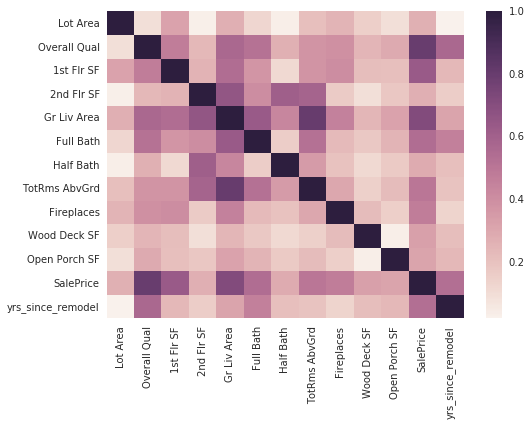

In [18]:
#Remove numerical collinear features - 'TotRms AbvGrd' and 'Gr Liv Area'
numerical_cols = data.select_dtypes('int', 'float')
abs_corrs = numerical_cols.corr().abs()
sns.heatmap(abs_corrs)
data = data.drop("TotRms AbvGrd", axis=1)
top_numerical = top_numerical.drop("TotRms AbvGrd")
print(data.columns)

In [19]:
#Convert ordinal objects to numerical scale.
qual_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}

func_map = {'Typ': 1, 'Min1': 2, 'Min2': 3, 'Mod': 4, 
                    'Maj1': 5, 'Maj2': 6, 'Sev': 7, 'Sal': 8}

object_scale_map = {'Exter Qual': qual_map, 'Exter Cond': qual_map, 
                'Heating QC': qual_map,'Kitchen Qual': qual_map, 
                'Functional': func_map}

for key, scale in object_scale_map.items():
    data[key] = data[key].map(scale)


In [20]:
#Convert remaining category features to binary dummy features
category_cols = data.select_dtypes('category').columns
for col in category_cols:
    dummy_col = pd.get_dummies(data[col], prefix=col, drop_first=True)
    data = pd.concat([data, dummy_col], axis=1)
    data = data.drop(col, axis=1)
for col in data.columns:  
    print(col)  #Print cols for reference
    

Lot Area
Overall Qual
Exter Qual
Exter Cond
Heating QC
1st Flr SF
2nd Flr SF
Gr Liv Area
Full Bath
Half Bath
Kitchen Qual
Functional
Fireplaces
Wood Deck SF
Open Porch SF
SalePrice
yrs_since_remodel
MS SubClass_30
MS SubClass_40
MS SubClass_45
MS SubClass_50
MS SubClass_60
MS SubClass_70
MS SubClass_75
MS SubClass_80
MS SubClass_85
MS SubClass_90
MS SubClass_120
MS SubClass_150
MS SubClass_160
MS SubClass_180
MS SubClass_190
MS Zoning_C (all)
MS Zoning_FV
MS Zoning_I (all)
MS Zoning_RH
MS Zoning_RL
MS Zoning_RM
Lot Shape_IR2
Lot Shape_IR3
Lot Shape_Reg
Land Contour_HLS
Land Contour_Low
Land Contour_Lvl
Lot Config_CulDSac
Lot Config_FR2
Lot Config_FR3
Lot Config_Inside
Neighborhood_Blueste
Neighborhood_BrDale
Neighborhood_BrkSide
Neighborhood_ClearCr
Neighborhood_CollgCr
Neighborhood_Crawfor
Neighborhood_Edwards
Neighborhood_Gilbert
Neighborhood_Greens
Neighborhood_GrnHill
Neighborhood_IDOTRR
Neighborhood_Landmrk
Neighborhood_MeadowV
Neighborhood_Mitchel
Neighborhood_NAmes
Neighborhood_

In [21]:
#save category col lists
neighborhood = [col for col in data.columns if 'Neighborhood' in col]
ms_subclass = [col for col in data.columns if "MS SubClass" in col]
ms_zoning = [col for col in data.columns if "MS Zoning" in col]
lot_shape = [col for col in data.columns if "Lot Shape" in col]
land_contour = [col for col in data.columns if "Land Contour" in col]
lot_config = [col for col in data.columns if "Lot Config" in col]
condition_1 = [col for col in data.columns if "Condition 1" in col]
bldg_type = [col for col in data.columns if "Bldg Type" in col]
house_style = [col for col in data.columns if "House Style" in col]
roof_style = [col for col in data.columns if "Roof Style" in col]
exterior_first = [col for col in data.columns if "Exterior 1st" in col]
exterior_second = [col for col in data.columns if "Exterior 2nd" in col]
foundation = [col for col in data.columns if "Foundation" in col]
central_air = [col for col in data.columns if "Central Air" in col]
paved_drive = [col for col in data.columns if "Paved Drive" in col]

category_list = [neighborhood, ms_subclass, ms_zoning, lot_shape,
                land_contour, lot_config, condition_1, bldg_type,
                house_style, roof_style, exterior_first, exterior_second,
                foundation, central_air, paved_drive]


#### Outlier handling


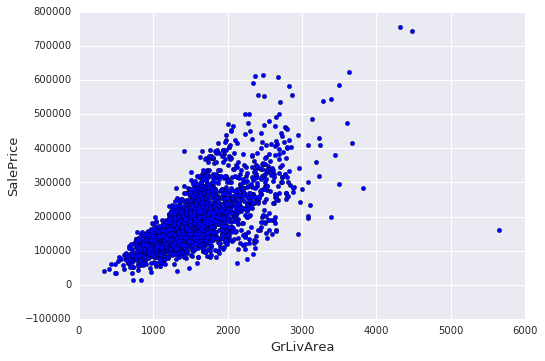

In [22]:
#Remove very large, very inexpensive properties.
fig, ax = plt.subplots()
ax.scatter(x = data['Gr Liv Area'], y = data['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

data = data[data['Gr Liv Area'] < 5000]

#### Normalize Data

In [23]:
#Normalize all columns except target using Min-Max
scaler = MinMaxScaler()
scaler_list = list(data.columns)
scaler_list.remove('SalePrice')
data[scaler_list] = scaler.fit_transform(data[scaler_list])

#### Update helper functions: 
- transform_features() to include Missing Values handling
- transform_features() to add 'yrs_since_remodel' / drop 'Year Built' / Remove nonsensical 'yrs_since_remodel' cases
- transform_features() to drop data leak columns
- transform_features() to drop PID and Order columns
- transform_features() to drop low variance columns
- transform_features() to convert numerical nominal data to category dtype
- transform_features() to drop numerical columns with low corr to target.
- transform_features() to convert ordinal categorical to numeric scale
- transform_features() to normalize data

In [38]:
def transform_features(a_dataframe):
    df = a_dataframe.copy()
    
    #MVs - fillna for numerical cols w/less than 5% MV.
    len_data = df.shape[0]
    mv_total = df.isnull().sum()
    mv_fill = mv_total[(mv_total < (len_data * .05)) & (mv_total > 0)]
    for col in mv_fill.index:
        if df[col].dtype in ('int', 'float'):
            mode = df[col].mode()
            df[col] = df[col].fillna(mode, inplace=True)
            
    ##MVs - drop cols missing > 5% of of total data.
    drop_cols = mv_total[mv_total > (len_data * 0.05)]
    df = df.drop(drop_cols.index, axis=1)

    ##MVs - dropping text columns with mv
    text_mv = df.select_dtypes('object').isnull().sum()
    text_mv = text_mv[text_mv > 0]
    df = df.drop(text_mv.index, axis=1)

    #Create 'yrs_since_remodel' feature / drop Year Built
    df['yrs_since_remodel'] = df['Yr Sold'] - df['Year Remod/Add']
    neg_rows = df[df['yrs_since_remodel'] < 0].index
    df = df.drop(neg_rows)
   
    #Drop Data Leak Columns - contain information not knowable prior to sale.
    data_leak_cols = ['Sale Condition', 'Yr Sold', 'Mo Sold', 'Sale Type']
    df = df.drop(data_leak_cols, axis=1)
    df = df.drop(['Year Built', 'Year Remod/Add'], axis=1)
    
    #Drop PID, Order Description Columns
    df = df.drop(['PID', 'Order'], axis=1)
    
    #Drop Low Variance Columns
    low_var_cols = []
    for col in df.columns:
        top_val_pct = df[col].value_counts().iloc[0] / df.shape[0]
        if top_val_pct >= 0.95:
            low_var_cols.append(col)
    df = df.drop(low_var_cols, axis=1)
    
    #Convert numeric/object columns that are nominal to categorical type
    categorical = ['MS SubClass', 'MS Zoning', 'Lot Shape',
                  'Land Contour', 'Lot Config', 'Neighborhood', 
                   'Condition 1', 'Bldg Type', 'House Style',
                  'Roof Style', 'Exterior 1st', 'Exterior 2nd',
                  'Foundation', 'Central Air', 'Paved Drive']
    for col in categorical:
        df[col] = df[col].astype('category')
        
    #Remove numerical features w/low correlation to target.
    numerical_cols = df.select_dtypes('int', 'float')
    abs_corrs = numerical_cols.corr().abs()
    sale_coeffs = abs_corrs['SalePrice'].sort_values()
    low_correlation_cols = list(sale_coeffs[sale_coeffs < 0.2].index)
    df = df.drop(low_correlation_cols, axis=1)
    
    #Remove numerical collinear features - 'TotRms AbvGrd' or 'Gr Liv Area'
    numerical_cols = df.select_dtypes('int', 'float')
    abs_corrs = numerical_cols.corr().abs()
    df = df.drop("TotRms AbvGrd", axis=1)
    
    #Convert ordinal objects to numerical scale.
    qual_map = {'Po': 1, 'Fa': 2, 
                'TA': 3, 'Gd': 4, 
                'Ex': 5}
    
    func_map = {'Typ': 1, 'Min1': 2, 'Min2': 3, 
                'Mod': 4, 'Maj1': 5, 'Maj2': 6, 
                'Sev': 7, 'Sal': 8}
    
    object_scale_map = {'Exter Qual': qual_map, 
                        'Exter Cond': qual_map, 
                        'Heating QC': qual_map,
                        'Kitchen Qual': qual_map,
                        'Functional': func_map}

    for key, scale in object_scale_map.items():
        df[key] = df[key].map(scale)
        
    #Convert remaining category features to binary dummy features
    category_cols = df.select_dtypes('category').columns
    for col in category_cols:
        dummy_col = pd.get_dummies(df[col], prefix=col, drop_first=True)
        df = pd.concat([df, dummy_col], axis=1)
        df = df.drop(col, axis=1)
        
    #Outlier handling
    df = df[df['Gr Liv Area'] < 5000]
        
    #Normalize all columns except target using Min-Max
    scaler = MinMaxScaler()
    scaler_list = list(df.columns)
    scaler_list.remove('SalePrice')
    df[scaler_list] = scaler.fit_transform(df[scaler_list])
    
    return df

def select_features(df):
    df = df.copy()
    feature_list = ["MS SubClass_30",
                "MS SubClass_40",
                "MS SubClass_45",
                "MS SubClass_50",
                "MS SubClass_70",
                "MS SubClass_75",
                "MS SubClass_80",
                "MS SubClass_85",
                "MS SubClass_90",
                "MS SubClass_120",
                "MS SubClass_150",
                "MS SubClass_160",
                "MS SubClass_180",
                "MS SubClass_190"]
    feature_list.append('SalePrice')
    df = df[feature_list]
    return df
    
def train_and_test(df, k=0):
    #df shape
    half_split = int(df.shape[0] / 2)
    
    #If k==0, 50/50 holdout validation
    if k == 0:
        #partition data
        train = df[:half_split]
        test = df[half_split:]

        #Select features
        train_df = select_features(train)
        train_numeric = train_df.select_dtypes(include=['integer', 'float'])
        features = train_numeric.columns.drop("SalePrice")

        #fit and measure model performance - Linear Regression
        lr = LinearRegression()
        lr.fit(train_numeric[features], train_numeric['SalePrice'])
        test_predict = lr.predict(test[features])
        mse_test = mean_squared_error(test['SalePrice'], test_predict)
        rmse_test = np.sqrt(mse_test)
        return rmse_test
    
    #k==1, 50/50 cross validation
    if k == 1:
        rmses = []
        #shuffle data and partition to two folds
        shuffled_df = df.sample(frac=1, random_state=1)
        fold_one = shuffled_df[:half_split]
        fold_two = shuffled_df[half_split:]
        
        #train on fold 1, test on fold 2
        train = fold_one
        test = fold_two
        
        #Select features
        train_df = select_features(train)
        train_numeric = train_df.select_dtypes(include=['integer', 'float'])
        features = train_numeric.columns.drop("SalePrice")

        #fit and measure model performance - Linear Regression
        lr = LinearRegression()
        lr.fit(train_numeric[features], train_numeric['SalePrice'])
        test_predict = lr.predict(test[features])
        mse_test = mean_squared_error(test['SalePrice'], test_predict)
        rmses.append(np.sqrt(mse_test))
        
        #train on fold 2, test on fold 1  (CROSS-VALIDATE)
        train = fold_two
        test = fold_one
        
        #Select features  (CROSS-VALIDATE)
        train_df = select_features(train)
        train_numeric = train_df.select_dtypes(include=['integer', 'float'])
        features = train_numeric.columns.drop("SalePrice")

        #fit and measure model performance - Linear Regression  (CROSS-VALIDATE)
        lr = LinearRegression()
        lr.fit(train_numeric[features], train_numeric['SalePrice'])
        test_predict = lr.predict(test[features])
        mse_test = mean_squared_error(test['SalePrice'], test_predict)
        rmses.append(np.sqrt(mse_test))
        
        return np.mean(rmses)
    
    #If k > 1, K-Folds cross-validation
    if k > 1:
        rmses = []
        kf = KFold(n_splits=k, random_state=1, shuffle=True)
        
        for train_index, test_index, in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            
            #Select features
            train_df = select_features(train)
            train_numeric = train_df.select_dtypes(include=['integer', 'float'])
            features = train_numeric.columns.drop("SalePrice") 

            #fit and measure model performance - Linear Regression
            lr = LinearRegression()
            lr.fit(train_numeric[features], train_numeric['SalePrice'])
            test_predict = lr.predict(test[features])
            mse_test = mean_squared_error(test['SalePrice'], test_predict)
        rmses.append(np.sqrt(mse_test))
        
        return np.mean(rmses)


## Categorical Feature ranking

Test linear model performance using each group of dummy variables.

#### Univariate models:

In [39]:
#Reload data and test updated model
def reload_and_test(k=0):
    test_data = pd.read_csv('AmesHousing.tsv', delimiter='\t')
    data_transformed = transform_features(test_data)
    return train_and_test(data_transformed, k=k)
    

In [40]:
for col in category_list:
    def select_features(df):
        df = df.copy()
        feature_list = []
        feature_list = col.copy()
        feature_list.append('SalePrice')
        df = df[feature_list]
        return df
    score = reload_and_test(k=4)
    print("{}: \ \n{}\n".format(col, score))
    

['Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_Greens', 'Neighborhood_GrnHill', 'Neighborhood_IDOTRR', 'Neighborhood_Landmrk', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker']: \ 
54139.72193593212

['MS SubClass_30', 'MS SubClass_40', 'MS SubClass_45', 'MS SubClass_50', 'MS SubClass_60', 'MS SubClass_70', 'MS SubClass_75', 'MS SubClass_80', 'MS SubClass_85', 'MS SubClass_90', 'MS SubClass_120', 'MS SubClass_150', 'MS SubClass_160', 'MS SubClass_180', 'MS SubClass_190']: \ 
72184.39885155756

['MS Zoning_C (all)', 'MS Zoning_FV', '

In [41]:
#Univariate testing on numerical cols
for col in top_numerical:
    def select_features(df):
        df = df.copy()
        feature_list = [col]
        feature_list.append('SalePrice')
        df = df[feature_list]
        return df
    score = reload_and_test(k=1)
    print("{}: \ \n{}\n".format(col, score))
    


Overall Qual: \ 
47713.260408321

Gr Liv Area: \ 
55027.72537721192

1st Flr SF: \ 
61206.04216610615

Full Bath: \ 
67074.68115107407

yrs_since_remodel: \ 
67509.94446346826

Fireplaces: \ 
70255.41870388444

Wood Deck SF: \ 
75467.52509991688

Open Porch SF: \ 
75767.42488983343

Half Bath: \ 
76636.08190214586

2nd Flr SF: \ 
77100.28402725038

Lot Area: \ 
76917.59660535945



## Multivariate Models

In [42]:
category_list = [neighborhood, ms_subclass, ms_zoning, lot_shape,
                land_contour, lot_config, condition_1, bldg_type,
                house_style, roof_style, exterior_first, exterior_second,
                foundation, central_air, paved_drive]

{1: 48935.0, 2: 39362.0, 3: 36806.0, 4: 36792.0, 5: 35950.0, 6: 35725.0, 7: 35344.0, 8: 35430.0, 9: 35489.0, 10: 35387.0, 11: 35135.0}


(0, 11)

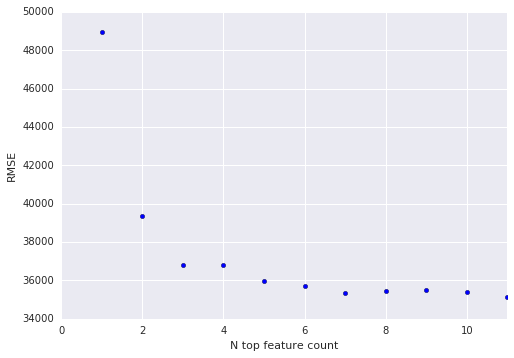

In [43]:
#multivariate numerical cols
feature_count_score = {}

for i in range(1, len(top_numerical) + 1):
    feature_count_score[i] = 0
    def select_features(df):
        df = df.copy()
        feature_list = list(top_numerical[:i])
        feature_list.append('SalePrice')
        feature_list = feature_list
        df = df[feature_list]
        return df
    feature_count_score[i] = round(reload_and_test(),0)

print(feature_count_score)
for key, value in feature_count_score.items():
    plt.scatter(key, value)
plt.xlabel('N top feature count')
plt.ylabel("RMSE")
plt.xlim((0, len(top_numerical)))

In [44]:
#multivariate numerical + category cols
feature_count_score = {}

for i in range(1, len(top_numerical) + 1):
    feature_count_score[i] = 0
    def select_features(df):
        df = df.copy()
        feature_list = (list(top_numerical[:i]) 
                        + neighborhood
                        + central_air
                        + foundation
                        + lot_shape
                        + land_contour
                        + lot_config
                        + bldg_type
                        + house_style
                        + roof_style)
        feature_list.append('SalePrice')
        feature_list = feature_list
        df = df[feature_list]
        return df
    feature_count_score[i] = round(reload_and_test(k=4),0)

print(feature_count_score)

{1: 40068.0, 2: 31171.0, 3: 30949.0, 4: 30920.0, 5: 30740.0, 6: 30469.0, 7: 30266.0, 8: 30215.0, 9: 30183.0, 10: 30172.0, 11: 29709.0}


## Strongest model: 

RMSE = $29,709 
- k=4
 - feature_list = (list(top_numerical[:11]) 
                        + neighborhood
                        + central_air
                        + foundation
                        + lot_shape
                        + land_contour
                        + lot_config
                        + bldg_type
                        + house_style
                        + roof_style)


# Improving this model (later):

1. In re-reading the data notes, some of the columns with missing values actually impute info about the data - pool for example. Null = no pool. This could bring several columns back in.
2. An ensemble model would likely improve the accuracy of predictions. For example, running a knn prediction and averaging it with the linear regression result.